### PromptHate : Multimodal Classification with Prompt Based RoBERTa

#### utils.py

In [56]:
import errno
import os
import torch.nn as nn
import torch
import os
import json
import pickle as pkl
import numpy as np
import torch
from tqdm import tqdm
import random
import pandas as pd
import h5py


def load_pkl(path):
    data=pkl.load(open(path,'rb'))
    return data

def read_hdf5(path):
    data=h5py.File(path,'rb')
    return data

def read_csv(path):
    data=pd.read_csv(path)
    return data

def read_csv_sep(path):
    data=pd.read_csv(path,sep='\t')
    return data

def dump_pkl(path,info):
    pkl.dump(info,open(path,'wb'))

def read_json(path):
    # utils.assert_exits(path)
    data=json.load(open(path,'rb'))
    '''in anet-qa returns a list'''
    return data

def pd_pkl(path):
    data=pd.read_pickle(path)
    return data

def read_jsonl(path):
    total_info=[]
    with open(path,'rb')as f:
        d=f.readlines()
    for i,info in enumerate(d):
        data=json.loads(info)
        total_info.append(data)
    return total_info


class KLDivergence(nn.Module):
    def __init__(self):
        super(KLDivergence, self).__init__()

    def forward(self,prob,logits):
        #length = (prob.sum(-1) > 0.001).sum()
        #print (prob.shape,logits.shape)
        bz,obj=prob.shape
        length=bz
        #prob=torch.softmax(prob,-1)
        #pred_prob = torch.softmax(logits, -1)
        pred_prob=logits
        #print (prob.sum(),pred_prob.sum())
        print ('external:',pred_prob[0],
               torch.sort(pred_prob[0],
                          dim=0,
               descending=True)[1][0])
        print ('visual:',prob[0],
               torch.sort(prob[0],
                          dim=0,
               descending=True)[1][0])
        loss = -prob * torch.log(pred_prob)
        loss = torch.sum(loss, -1)
        loss = torch.sum(loss) / length
        return loss

def assert_exits(path):
    assert os.path.exists(path), 'Does not exist : {}'.format(path)

def equal_info(a,b):
    assert len(a)==len(b),'File info not equal!'

def same_question(a,b):
    assert a==b,'Not the same question!'

class Logger(object):
    def __init__(self,output_dir):
        dirname=os.path.dirname(output_dir)
        if not os.path.exists(dirname):
            os.mkdir(dirname)
        self.log_file=open(output_dir,'w')
        self.infos={}

    def append(self,key,val):
        vals=self.infos.setdefault(key,[])
        vals.append(val)

    def log(self,extra_msg=''):
        msgs=[extra_msg]
        for key, vals in self.infos.iteritems():
            msgs.append('%s %.6f' %(key,np.mean(vals)))
        msg='\n'.joint(msgs)
        self.log_file.write(msg+'\n')
        self.log_file.flush()
        self.infos={}
        return msg

    def write(self,msg):
        self.log_file.write(msg+'\n')
        self.log_file.flush()
        print(msg)

### Multimodal_Data.py

In [57]:
class Multimodal_Data():
    #mem, off, harm
    def __init__(self,opt,tokenizer,dataset,mode='train',few_shot_index=0):
        super(Multimodal_Data,self).__init__()
        self.opt=opt
        self.tokenizer = tokenizer
        self.mode=mode
        if self.opt.FEW_SHOT:
            self.few_shot_index=str(few_shot_index)
            self.num_shots=self.opt.NUM_SHOTS
            print ('Few shot learning setting for Iteration:',self.few_shot_index)
            print ('Number of shots:',self.num_shots)
        self.image_folder=self.opt.IMAGE_FOLDER
        self.num_ans=self.opt.NUM_LABELS
        #maximum length for a single sentence
        self.length=self.opt.LENGTH
        #maximum length of the concatenation of sentences
        self.total_length=self.opt.TOTAL_LENGTH
        self.num_sample=self.opt.NUM_SAMPLE
        self.add_ent=self.opt.ADD_ENT
        self.add_dem=self.opt.ADD_DEM
#         self.add_gpt=self.opt.ADD_GPT
        print ('Adding exntity information?',self.add_ent)
        print ('Adding demographic information?',self.add_dem)
        self.fine_grind=self.opt.FINE_GRIND
        print ('Using target information?',self.fine_grind)

        if opt.FINE_GRIND:
            #target information
            if self.opt.DATASET=='mem':
                self.label_mapping_word={0:'nobody',
                                         1:'race',
                                         2:'disability',
                                         3:'nationality',
                                         4:'sex',
                                         5:'religion'}
            elif self.opt.DATASET=='harm':
                self.label_mapping_word={0:'nobody',
                                         1:'society',
                                         2:'individual',
                                         3:'community',
                                         4:'organization'}
                self.attack_list={'society':0,
                                  'individual':1,
                                  'community':2,
                                  'organization':3}
                self.attack_file=load_pkl(os.path.join(self.opt.DATA,
                                                       'domain_splits','harm_trgt.pkl'))
            self.template="*<s>**sent_0*.*_It_was_targeting*label_**</s>*"
        else:
            self.label_mapping_word={0:self.opt.POS_WORD,
                                     1:self.opt.NEG_WORD}
            self.template="*<s>**sent_0*.*_It_was*label_**</s>*"

        self.label_mapping_id={}
        for label in self.label_mapping_word.keys():
            mapping_word=self.label_mapping_word[label]
            #add space already
            assert len(tokenizer.tokenize(' ' + self.label_mapping_word[label])) == 1
            self.label_mapping_id[label] = \
            tokenizer._convert_token_to_id(
                tokenizer.tokenize(' ' + self.label_mapping_word[label])[0])
            print ('Mapping for label %d, word %s, index %d' %
                   (label,mapping_word,self.label_mapping_id[label]))
        #implementation for one template now


        self.template_list=self.template.split('*')
        print('Template:', self.template)
        print('Template list:',self.template_list)
        self.special_token_mapping = {
            '<s>': tokenizer.convert_tokens_to_ids('<s>'),
            '<mask>': tokenizer.mask_token_id,
            '<pad>': tokenizer.pad_token_id, #1 for roberta
            '</s>': tokenizer.convert_tokens_to_ids('<\s>')
        }

        if self.opt.DEM_SAMP:
            print ('Using demonstration sampling strategy...')
            self.img_rate=self.opt.IMG_RATE
            self.text_rate=self.opt.TEXT_RATE
            self.samp_rate=self.opt.SIM_RATE
            print ('Image rage for measuring CLIP similarity:',self.img_rate)
            print ('Text rage for measuring CLIP similarity:',self.text_rate)
            print ('Sampling from top:',self.samp_rate*100.0,'examples')
            self.clip_clean=self.opt.CLIP_CLEAN
            clip_path=os.path.join(
                self.opt.CAPTION_PATH,
                dataset,dataset+'_sim_scores.pkl')
            print ('Clip feature path:',clip_path)
            self.clip_feature=load_pkl(clip_path)

        self.support_examples=self.load_entries('train')
        print ('Length of supporting example:',len(self.support_examples))
        self.entries=self.load_entries(mode)
        if self.opt.DEBUG:
            self.entries=self.entries[:128]
        self.prepare_exp()
        print ('The length of the dataset for:',mode,'is:',len(self.entries))

    def load_entries(self,mode):
        #print ('Loading data from:',self.dataset)
        #only in training mode, in few-shot setting the loading will be different
        if self.opt.FEW_SHOT and mode=='train':
            path=os.path.join(self.opt.DATA,
                              'domain-splits',
                              self.opt.DATASET+'_'+str(self.num_shots)+'_'+self.few_shot_index+'.json')
        else:
            path=os.path.join(self.opt.DATA,
                              'domain-splits',
                              self.opt.DATASET+'_'+mode+'.json')
        data=read_json(path)
        cap_path=os.path.join(self.opt.CAPTION_PATH,
                              self.opt.DATASET+'-'+self.opt.PRETRAIN_DATA,
                              self.opt.IMG_VERSION+'_captions.pkl')
        captions=load_pkl(cap_path)
        entries=[]

        for k,row in enumerate(data):
            label=row['label']
            img=row['img']
#             img = os.path.join(self.image_folder, row['img'])
#             print(img)
#             cap=captions[img.split('.')[0]][:-1]#remove the punctuation in the end
#             sent=row['clean_sent']
#             remember the punctuations at the end of each sentence
#             cap="the caption for image is : "+cap+' . the description for images is '+sent+' . the entities in the image are '
        
            cap=row['description']
#             if 'json' in row['description']:
#                 print("noooooooooooooo")
            #whether using external knowledge
            if self.add_ent:
                cap=cap+row['entity']+'"  the race of entities in the images is '
            if self.add_dem:
                cap=cap+' . '+row['race']+' . '
            entry={
                'cap':cap.strip(),
                'label':label,
                'img':img
            }
            if self.fine_grind:
                if self.opt.DATASET=='mem':
                    if label==0:
                        #[1,0,0,0,0,0]
                        entry['attack']=[1]+row['attack']
                    else:
                        entry['attack']=[0]+row['attack']
                elif self.opt.DATASET=='harm':
                    if label==0:
                        #[1,0,0,0,0,0]
                        entry['attack']=[1,0,0,0,0]
                    else:
                        attack=[0,0,0,0,0]
                        attack_idx=self.attack_list[self.attack_file[img]]+1
                        attack[attack_idx]=1
                        entry['attack']=attack
            entries.append(entry)
        return entries

    def enc(self,text):
        return self.tokenizer.encode(text, add_special_tokens=False)

    def prepare_exp(self):
        ###add sampling
        support_indices = list(range(len(self.support_examples)))
        self.example_idx = []
        for sample_idx in tqdm(range(self.num_sample)):
            for query_idx in range(len(self.entries)):
                if self.opt.DEM_SAMP:
                    #filter dissimilar demonstrations
                    candidates= [support_idx for support_idx in support_indices
                                 if support_idx != query_idx or self.mode != "train"]
                    sim_score=[]
                    count_each_label = {label: 0 for label in range(self.opt.NUM_LABELS)}
                    context_indices=[]
                    clip_info_que=self.clip_feature[self.entries[query_idx]['img']]

                    #similarity computation
                    for support_idx in candidates:
                        img=self.support_examples[support_idx]['img']
                        #this cost a lot of computation
                        #unnormalized: the same scale -- 512 dimension
                        if self.clip_clean:
                            img_sim=clip_info_que['clean_img'][img]
                        else:
                            img_sim=clip_info_que['img'][img]
                        text_sim=clip_info_que['text'][img]
                        total_sim=self.img_rate*img_sim+self.text_rate*text_sim
                        sim_score.append((support_idx,total_sim))
                    sim_score.sort(key=lambda x: x[1],reverse=True)

                    #top opt.SIM_RATE entities for each label
                    num_valid=int(len(sim_score)//self.opt.NUM_LABELS*self.samp_rate)
                    """
                    if self.opt.DEBUG:
                        print ('Valid for each class:',num_valid)
                    """

                    for support_idx, score in sim_score:
                        cur_label=self.support_examples[support_idx]['label']
                        if count_each_label[cur_label]<num_valid:
                            count_each_label[cur_label]+=1
                            context_indices.append(support_idx)
                else:
                    #exclude the current example during training
                    context_indices = [support_idx for support_idx in support_indices
                                       if support_idx != query_idx or self.mode != "train"]
                #available indexes for supporting examples
                self.example_idx.append((query_idx, context_indices, sample_idx))

    def select_context(self, context_examples):
        """
        Select demonstrations from provided examples.
        """
        num_labels=self.opt.NUM_LABELS
        max_demo_per_label = 1
        counts = {k: 0 for k in range(num_labels)}
        if num_labels == 1:
            # Regression
            counts = {'0': 0, '1': 0}
        selection = []
        """
        # Sampling strategy from LM-BFF
        if self.opt.DEBUG:
            print ('Number of context examples available:',len(context_examples))
        """
        order = np.random.permutation(len(context_examples))
        for i in order:
            label = context_examples[i]['label']
            if num_labels == 1:
                # Regression
                #No implementation currently
                label = '0' if\
                float(label) <= median_mapping[self.args.task_name] else '1'
            if counts[label] < max_demo_per_label:
                selection.append(context_examples[i])
                counts[label] += 1
            if sum(counts.values()) == len(counts) * max_demo_per_label:
                break

        assert len(selection) > 0
        return selection

    def process_prompt(self, examples,
                       first_sent_limit, other_sent_limit):
        if self.fine_grind:
            prompt_arch=' It was targeting '
        else:
            prompt_arch=' It was '
        #currently, first and other limit are the same
        input_ids = []
        attention_mask = []
        mask_pos = None # Position of the mask token
        concat_sent=""
        for segment_id, ent in enumerate(examples):
            #tokens for each example
            new_tokens=[]
            if segment_id==0:
                #implementation for the querying example
                new_tokens.append(self.special_token_mapping['<s>'])
                length=first_sent_limit
                temp=prompt_arch+'<mask>'+' . </s>'
            else:
                length=other_sent_limit
                if self.fine_grind:
                    if ent['label']==0:
                        label_word=self.label_mapping_word[0]
                    else:
                        attack_types=[i for i, x in enumerate(ent['attack']) if x==1]
                        #only for meme
                        if len(attack_types)==0:
                            attack_idx=random.randint(1,5)
                        #randomly pick one
                        #already padding nobody to the head of the list
                        else:
                            order=np.random.permutation(len(attack_types))
                            attack_idx=attack_types[order[0]]
                        label_word=self.label_mapping_word[attack_idx]
                else:
                    label_word=self.label_mapping_word[ent['label']]
                temp=prompt_arch+label_word+' . </s>'
            new_tokens+=self.enc(' '+ent['cap'])
            #truncate the sentence if too long
            new_tokens=new_tokens[:length]
            new_tokens+=self.enc(temp)
            whole_sent=' '+ent['cap']+temp
            concat_sent+=whole_sent

            #update the prompts
            input_ids+=new_tokens
            attention_mask += [1 for i in range(len(new_tokens))]
        """
        if self.opt.DEBUG and self.opt.DEM_SAMP==False:
            print (concat_sent)
        """
        while len(input_ids) < self.total_length:
            input_ids.append(self.special_token_mapping['<pad>'])
            attention_mask.append(0)
        if len(input_ids) > self.total_length:
            input_ids = input_ids[:self.total_length]
            attention_mask = attention_mask[:self.total_length]
        mask_pos = [input_ids.index(self.special_token_mapping['<mask>'])]

        # Make sure that the masked position is inside the max_length
        assert mask_pos[0] < self.total_length
        result = {'input_ids': input_ids,
                  'sent':'<s>'+concat_sent,
                  'attention_mask': attention_mask,
                  'mask_pos': mask_pos}
        return result


    def __getitem__(self,index):
        #query item
        entry=self.entries[index]
        #bootstrap_idx --> sample_idx
        query_idx, context_indices, bootstrap_idx = self.example_idx[index]
        #one example from each class
        supports = self.select_context(
            [self.support_examples[i] for i in context_indices])
        exps=[]
        exps.append(entry)
        exps.extend(supports)
        prompt_features = self.process_prompt(
            exps,
            self.length,
            self.length
        )

        vid=entry['img']
        #label=torch.tensor(self.label_mapping_id[entry['label']])
        label=torch.tensor(entry['label'])
        target=torch.from_numpy(np.zeros((self.num_ans),dtype=np.float32))
        target[label]=1.0

        cap_tokens=torch.Tensor(prompt_features['input_ids'])
        mask_pos=torch.LongTensor(prompt_features['mask_pos'])
        mask=torch.Tensor(prompt_features['attention_mask'])
        batch={
            'sent':prompt_features['sent'],
            'mask':mask,
            'img':vid,
            'target':target,
            'cap_tokens':cap_tokens,
            'mask_pos':mask_pos,
            'label':label
        }
        if self.fine_grind:
            batch['attack']=torch.Tensor(entry['attack'])
        #print (batch)
        return batch

    def __len__(self):
        return len(self.entries)



In [58]:
torch.cuda.empty_cache()

In [59]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from transformers import get_linear_schedule_with_warmup,AdamW

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def bce_for_loss(logits,labels):
    loss=nn.functional.binary_cross_entropy_with_logits(logits, labels)
    loss*=labels.size(1)
    return loss
def cross_entropy_loss(logits, labels):
    # logits: raw output from the model (not softmaxed), of shape [batch_size, num_classes]
    # labels: class indices for each sample in the batch, of shape [batch_size]
    loss = nn.functional.cross_entropy(logits, labels)
    return loss
def compute_auc_score(logits,label):
    bz=logits.shape[0]
    logits=logits.cpu().numpy()
    label=label.cpu().numpy()
    auc=roc_auc_score(label,logits,average='weighted')*bz
    return auc

def compute_score(logits,labels):
    #print (logits,logits.shape)
    logits=torch.max(logits,1)[1]
    #print (logits)
    one_hot=torch.zeros(*labels.size()).cuda()
    one_hot.scatter_(1,logits.view(-1,1),1)
    score=one_hot * labels
    return score.sum().float()

def compute_scaler_score(logits,labels):
    #print (logits,logits.shape)
    logits=torch.max(logits,1)[1]
    labels=labels.squeeze(-1)
    score=(logits==labels).int()
    #print (score.sum(),labels,logits)
    return score.sum().float()


def log_hyperpara(logger,opt):
    dic = vars(opt)
    for k,v in dic.items():
        logger.write(k + ' : ' + str(v))

def train_for_epoch(opt,model,train_loader,test_loader):
    #initialization of saving path
    if opt.SAVE:
        model_path=os.path.join('../models',
                          '_'.join([opt.MODEL,opt.DATASET]))
        if os.path.exists(model_path)==False:
            os.mkdir(model_path)
    #multi-qeury configuration
    if opt.MULTI_QUERY:
        from transformers import RobertaTokenizer
#         tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        tokenizer = RobertaTokenizer.from_pretrained(opt.BASE_MODEL)
    #initialization of logger
    log_path=os.path.join(opt.DATASET)
    if os.path.exists(log_path)==False:
        os.mkdir(log_path)
    # logger=utils.Logger(os.path.join(log_path,str(opt.SAVE_NUM)+'.txt'))
    # log_hyperpara(logger,opt)
    # logger.write('Length of training set: %d, length of testing set: %d' %
    #              (len(train_loader.dataset),len(test_loader.dataset)))

    if opt.MODEL=='pbm':
        #initialization of optimizer
        params = {}
        for n, p in model.named_parameters():
            if opt.FIX_LAYERS > 0:
                if 'encoder.layer' in n:
                    try:
                        layer_num = int(n[n.find('encoder.layer') + 14:].split('.')[0])
                    except:
                        print(n)
                        raise Exception("")
                    if layer_num >= opt.FIX_LAYERS:
                        print('yes', n)
                        params[n] = p
                    else:
                        print('no ', n)
                elif 'embeddings' in n:
                    print('no ', n)
                else:
                    print('yes', n)
                    params[n] = p
            else:
                params[n] = p
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in params.items() if not any(nd in n for nd in no_decay)],
                "weight_decay": opt.WEIGHT_DECAY,
            },
            {
                "params": [p for n, p in params.items() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]

        optim = AdamW(
            optimizer_grouped_parameters,
            lr=opt.LR_RATE,
            eps=opt.EPS,
        )
    else:
        params=model.parameters()
        optim=AdamW(params,
                    lr=1e-5,
                    eps=1e-8
                   )
    num_training_steps=len(train_loader) * opt.EPOCHS
    scheduler=\
    get_linear_schedule_with_warmup(optim,
                                    num_warmup_steps=0,
                                    num_training_steps=num_training_steps
                                   )
    loss_fn=torch.nn.BCELoss()
    loss_fct = nn.KLDivLoss(log_target=True)
    #strat training
    record_auc=[]
    record_acc=[]
    for epoch in range(opt.EPOCHS):
        model.train(True)
        total_loss=0.0
        scores=0.0
        for i,batch in enumerate(train_loader):
            #break
            cap=batch['cap_tokens'].long().cuda()
            label=batch['label'].float().cuda().view(-1,1)
            mask=batch['mask'].cuda()
            target=batch['target'].cuda()
            feat=None
            if opt.MODEL=='pbm':
                mask_pos=batch['mask_pos'].cuda()
                logits=model(cap,mask,mask_pos,feat)
                if opt.FINE_GRIND:
                    attack=batch['attack'].cuda()#B,6
                    #print (logits)
                    #print (attack)
                    #logits=logits*attack
                    logits[:,1]=torch.sum(logits[:,1:],dim=1)
                    logits=logits[:,:2]
                #print (logits.shape,attack.shape)
            elif opt.MODEL=='roberta':
                if opt.UNIMODAL==False:
                    feat=batch['feat'].cuda()
                logits=model(cap,mask,feat)
#             loss=bce_for_loss(logits,target)
            loss=cross_entropy_loss(logits,target)
            #print (logits,target)
            batch_score=compute_score(logits,target)
            scores+=batch_score
            if i%100==0:
              print ('Epoch:',epoch,'Iteration:', i, loss.item(),batch_score)
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()

            total_loss+=loss
        model.train(False)
        scores/=len(train_loader.dataset)
        print("accuracy on trian", scores)
        if opt.MULTI_QUERY==False:
            eval_acc,eval_auc=eval_model(opt,model,test_loader)
        else:
            eval_acc,eval_auc=eval_multi_model(opt,model,tokenizer)
        record_auc.append(eval_auc)
        record_acc.append(eval_acc)
        
        print("current accuracy on test",eval_acc)
        print("current AUC on test",eval_auc)
#         logger.write('Epoch %d' %(epoch))
#         logger.write('\ttrain_loss: %.2f, accuracy: %.2f' % (total_loss,
#                                                              scores*100.0))
#         logger.write('\tevaluation auc: %.2f, accuracy: %.2f' % (eval_auc,
#                                                                  eval_acc))
    max_idx=sorted(range(len(record_auc)),
                   key=lambda k: record_auc[k]+record_acc[k],
                   reverse=True)[0]
#     logger.write('Maximum epoch: %d' %(max_idx))
#     logger.write('\tevaluation auc: %.2f, accuracy: %.2f' % (record_auc[max_idx],
#                                                              record_acc[max_idx]))

def eval_model(opt,model,test_loader):
    scores=0.0
    auc=0.0
    len_data=len(test_loader.dataset)
    print ('Length of test set:',len_data)
    total_logits=[]
    total_labels=[]
    for i,batch in enumerate(test_loader):
        with torch.no_grad():
            cap=batch['cap_tokens'].long().cuda()
            label=batch['label'].float().cuda().view(-1,1)
            mask=batch['mask'].cuda()
            target=batch['target'].cuda()
            feat=None
            if opt.MODEL=='pbm':
                mask_pos=batch['mask_pos'].cuda()
                logits=model(cap,mask,mask_pos,feat)
                if opt.FINE_GRIND:
                    #attack=batch['attack'].cuda()#B,6
                    #logits=logits*attack
                    logits[:,1]=torch.sum(logits[:,1:],dim=1)
                    logits=logits[:,:2]

            elif opt.MODEL=='roberta':
                if opt.UNIMODAL==False:
                    feat=batch['feat'].cuda()
                logits=model(cap,mask,feat)

            batch_score=compute_score(logits,target)
            scores+=batch_score
            norm_logits=F.softmax(logits,dim=-1)[:,1].unsqueeze(-1)

            total_logits.append(norm_logits)
            total_labels.append(label)
    total_logits=torch.cat(total_logits,dim=0)
    total_labels=torch.cat(total_labels,dim=0)
    print (total_logits.shape,total_labels.shape)
    auc=compute_auc_score(total_logits,total_labels)
    #print (auc)
    return scores*100.0/len_data,auc*100.0/len_data

def eval_multi_model(opt,model, tokenizer):
    num_queries=opt.NUM_QUERIES
    labels_record={}
    logits_record={}
    prob_record={}
    for k in range(num_queries):
        test_set=Multimodal_Data(opt,tokenizer,opt.DATASET,'test')
        test_loader=DataLoader(test_set,
                               opt.BATCH_SIZE,
                               shuffle=False,
                               num_workers=1)
        len_data=len(test_loader.dataset)
        print ('Length of test set:',len_data,'Query:',k)
        for i,batch in enumerate(test_loader):
            with torch.no_grad():
                cap=batch['cap_tokens'].long().cuda()
                label=batch['label'].float().cuda().view(-1,1)
                mask=batch['mask'].cuda()
                mask_pos=batch['mask_pos'].cuda()
                logits=model(cap,mask,mask_pos)
                if opt.FINE_GRIND:
                    #attack=batch['attack'].cuda()#B,6
                    #logits=logits*attack
                    logits[:,1]=torch.sum(logits[:,1:],dim=1)
                    logits=logits[:,:2]
                target=batch['target'].cuda()
                img=batch['img']
                norm_prob=F.softmax(logits,dim=-1)
                norm_logits=norm_prob[:,1].unsqueeze(-1)

                bz=cap.shape[0]
                for j in range(bz):
                    cur_img=img[j]
                    cur_logits=norm_logits[j:j+1]
                    #should normalize to the same scale
                    cur_prob=norm_prob[j:j+1]
                    if k==0:
                        cur_label=label[j:j+1]
                        labels_record[cur_img]=cur_label
                        logits_record[cur_img]=cur_logits
                        prob_record[cur_img]=cur_prob
                    else:
                        logits_record[cur_img]+=cur_logits
                        prob_record[cur_img]+=cur_prob
    labels=[]
    logits=[]
    probs=[]
    for name in labels_record.keys():
        labels.append(labels_record[name])
        logits.append(logits_record[name]/num_queries)
        probs.append(prob_record[name]/num_queries)

    logits=torch.cat(logits,dim=0)
    labels=torch.cat(labels,dim=0)
    probs=torch.cat(probs,dim=0)
    
    predicted_classes = torch.argmax(probs, dim=1)
    class_names=["good","bad"]
    plot_confusion_matrix(labels.cpu().numpy(), predicted_classes.cpu().numpy(), class_names)

    # Store incorrect predictions
#     incorrect_indices = (predicted_classes != labels).nonzero(as_tuple=True)[0]
    #     incorrect_predictions = {
    #         'indices': incorrect_indices,
    #         'true_labels': labels[incorrect_indices],
    #         'predicted_labels': predicted_classes[incorrect_indices],
    #         'probs': probs[incorrect_indices]
    #     }

    scores=compute_scaler_score(probs,labels)
    auc=compute_auc_score(logits,labels)
    return scores*100.0/len_data,auc*100.0/len_data


In [60]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
    DATASET: str
    FEW_SHOT: bool
    FINE_GRIND: bool
    NUM_SHOTS: int
    MODEL: str
    UNIMODAL: bool
    DATA: str
    CAPTION_PATH: str
    RESULT: str
    FEAT_DIM: int
    CLIP_DIM: int
    BERT_DIM: int
    ROBERTA_DIM: int
    NUM_FOLD: int
    EMB_DIM: int
    NUM_LABELS: int
    POS_WORD: str
    NEG_WORD: str
    DEM_SAMP: bool
    SIM_RATE: float
    IMG_RATE: float
    TEXT_RATE: float
    CLIP_CLEAN: bool
    MULTI_QUERY: bool
    NUM_QUERIES: int
    EMB_DROPOUT: float
    FC_DROPOUT: float
    WEIGHT_DECAY: float
    LR_RATE: float
    EPS: float
    BATCH_SIZE: int
    FIX_LAYERS: int
    MID_DIM: int
    NUM_HIDDEN: int
    LENGTH: int
    TOTAL_LENGTH: int
    PREFIX_LENGTH: int
    NUM_SAMPLE: int
    NUM_LAYER: int
    MODEL_NAME: str
    PRETRAIN_DATA: str
    IMG_VERSION: str
    MAPPING_TYPE: str
    ADD_ENT: bool
    ADD_DEM: bool
    DEBUG: bool
    SAVE: bool
    SAVE_NUM: int
    EPOCHS: int
    SEED: int
    CUDA_DEVICE: int
    WARM_UP: int
    TRANS_LAYER: int
    NUM_HEAD: int
    IMAGE_FOLDER:str
    BASE_MODEL:str




In [61]:
import torch
import torch.nn as nn
from transformers import RobertaForMaskedLM
from transformers import DistilBertForMaskedLM
class RobertaPromptModel(nn.Module):
    def __init__(self,label_list,base_model):
        super(RobertaPromptModel, self).__init__()
        self.label_word_list=label_list
        self.roberta = RobertaForMaskedLM.from_pretrained(base_model)
#         self.roberta = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased')
    def forward(self,tokens,attention_mask,mask_pos,feat=None):
        batch_size = tokens.size(0)
        #the position of word for prediction
        if mask_pos is not None:
            mask_pos = mask_pos.squeeze()

        out = self.roberta(tokens,
                           attention_mask)
        prediction_mask_scores = out.logits[torch.arange(batch_size),
                                          mask_pos]

        logits = []
        for label_id in range(len(self.label_word_list)):
            logits.append(prediction_mask_scores[:,
                                                 self.label_word_list[label_id]
                                                ].unsqueeze(-1))
            #print(prediction_mask_scores[:, self.label_word_list[label_id]].shape)
        logits = torch.cat(logits, -1)
        #print(logits.shape)
        return logits


def build_baseline(opt,label_list):
    print (label_list)
    return RobertaPromptModel(label_list,opt.BASE_MODEL)



In [62]:
import torch
import numpy as np
import random

# import config
import os
# from train import train_for_epoch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer
from transformers import DistilBertTokenizer


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 49.08it/s]


The length of the dataset for: train is: 400
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 63.40it/s]

The length of the dataset for: test is: 400
[205, 1099]


no  roberta.roberta.embeddings.word_embeddings.weight
no  roberta.roberta.embeddings.position_embeddings.weight
no  roberta.roberta.embeddings.token_type_embeddings.weight
no  roberta.roberta.embeddings.LayerNorm.weight
no  roberta.roberta.embeddings.LayerNorm.bias
no  roberta.roberta.encoder.layer.0.attention.self.query.weight
no  roberta.roberta.encoder.layer.0.attention.self.query.bias
no  roberta.roberta.encoder.layer.0.attention.self.key.weight
no  roberta.roberta.encoder.layer.0.attention.self.key.bias
no  roberta.roberta.encoder.layer.0.attention.self.value.weight
no  roberta.roberta.encoder.layer.0.attention.self.value.bias
no  roberta.roberta.encoder.layer.0.attention.output.dense.weight
no  roberta.roberta.encoder.layer.0.attention.output.dense.bias
no  roberta.roberta.encoder.layer.0.attention.output.LayerNorm.weight
no  roberta.roberta.encoder.layer.0.attention.output.LayerNorm.bias
no  roberta.roberta.encoder.layer.0.intermediate.dense.weight
no  roberta.roberta.encoder.la

100%|██████████| 1/1 [00:00<00:00, 67.76it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 74.83it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 67.60it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 74.26it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


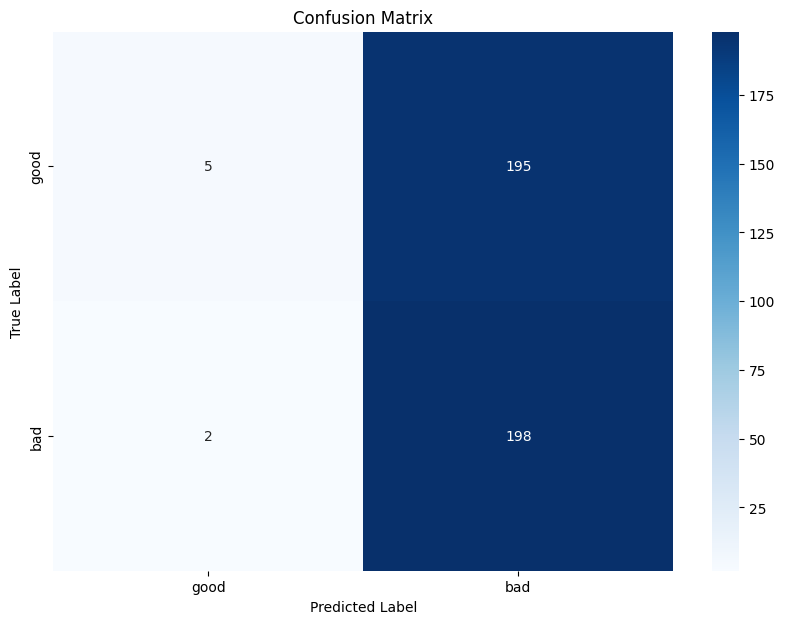

current accuracy on test tensor(50.7500, device='cuda:0')
current AUC on test 59.3375
Epoch: 1 Iteration: 0 1.4873347282409668 tensor(8., device='cuda:0')
accuracy on trian tensor(0.5800, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 61.46it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 72.89it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 76.53it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 76.61it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


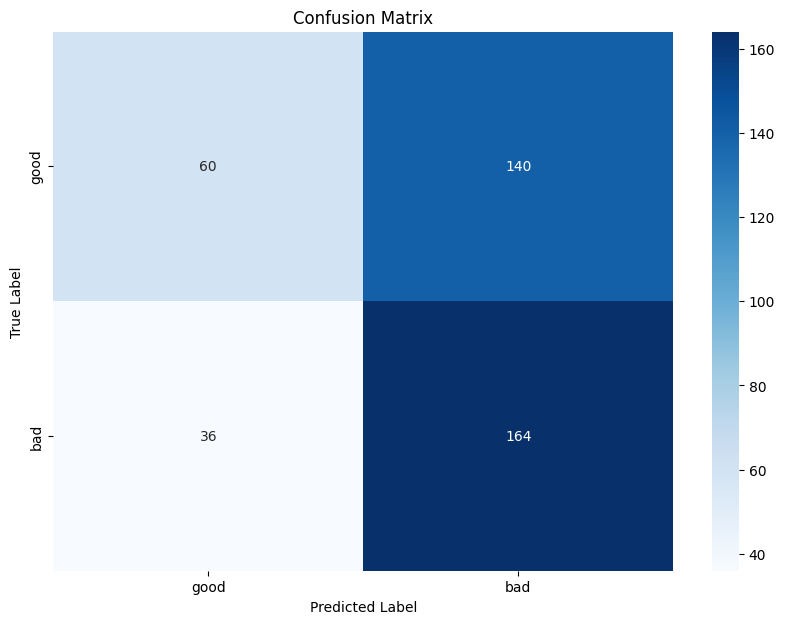

current accuracy on test tensor(56., device='cuda:0')
current AUC on test 65.2925
Epoch: 2 Iteration: 0 1.4201576709747314 tensor(7., device='cuda:0')
accuracy on trian tensor(0.6425, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 65.49it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 72.50it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 69.06it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 71.86it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


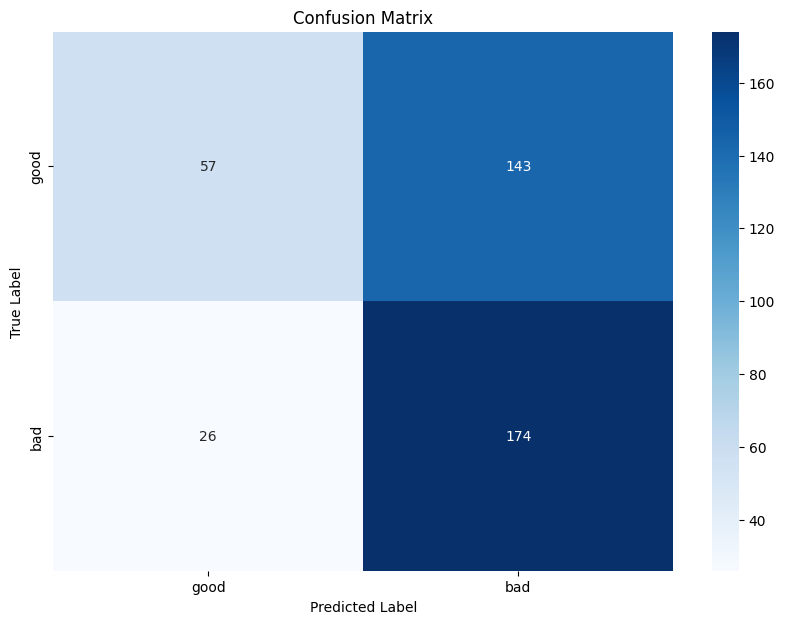

current accuracy on test tensor(57.7500, device='cuda:0')
current AUC on test 69.01249999999999
Epoch: 3 Iteration: 0 1.2766637802124023 tensor(9., device='cuda:0')
accuracy on trian tensor(0.6675, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 75.67it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 68.59it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 70.17it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 76.04it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


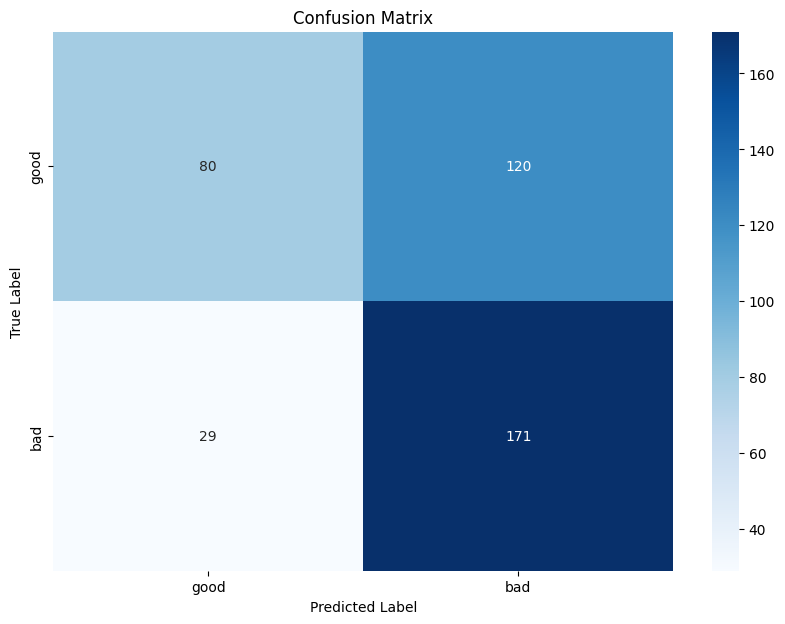

current accuracy on test tensor(62.7500, device='cuda:0')
current AUC on test 71.47749999999999
Epoch: 4 Iteration: 0 1.1319258213043213 tensor(12., device='cuda:0')
accuracy on trian tensor(0.7250, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 77.11it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 70.41it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 69.47it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 70.61it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


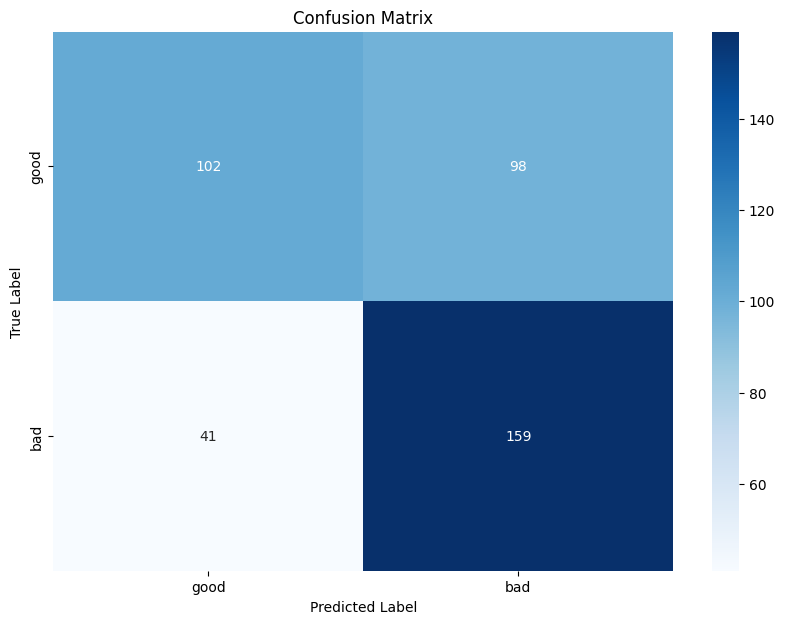

current accuracy on test tensor(65.2500, device='cuda:0')
current AUC on test 73.25
Epoch: 5 Iteration: 0 0.903109073638916 tensor(12., device='cuda:0')
accuracy on trian tensor(0.7525, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 69.64it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 61.66it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 73.75it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 79.03it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 75.58it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


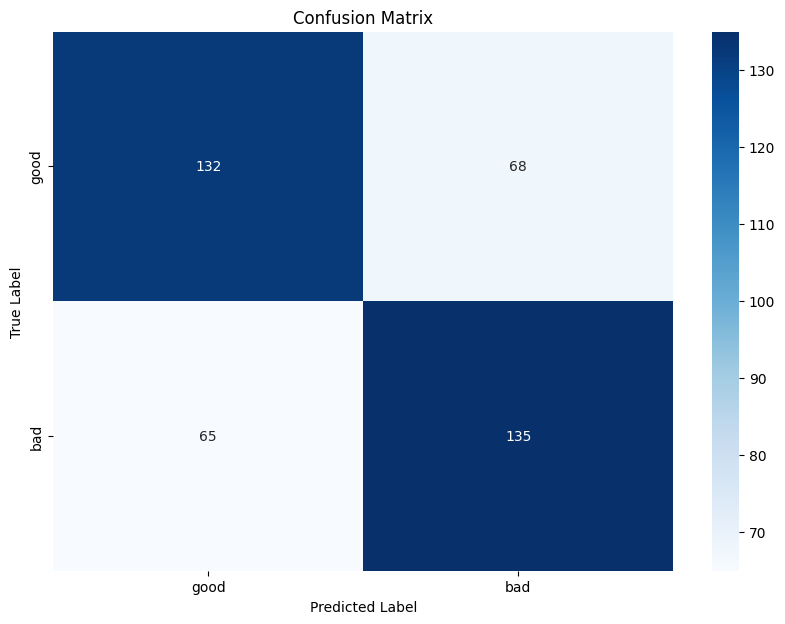

current accuracy on test tensor(66.7500, device='cuda:0')
current AUC on test 74.08250000000001
Epoch: 7 Iteration: 0 0.6188755035400391 tensor(14., device='cuda:0')
accuracy on trian tensor(0.8600, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 77.84it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 75.06it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 73.47it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 71.12it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


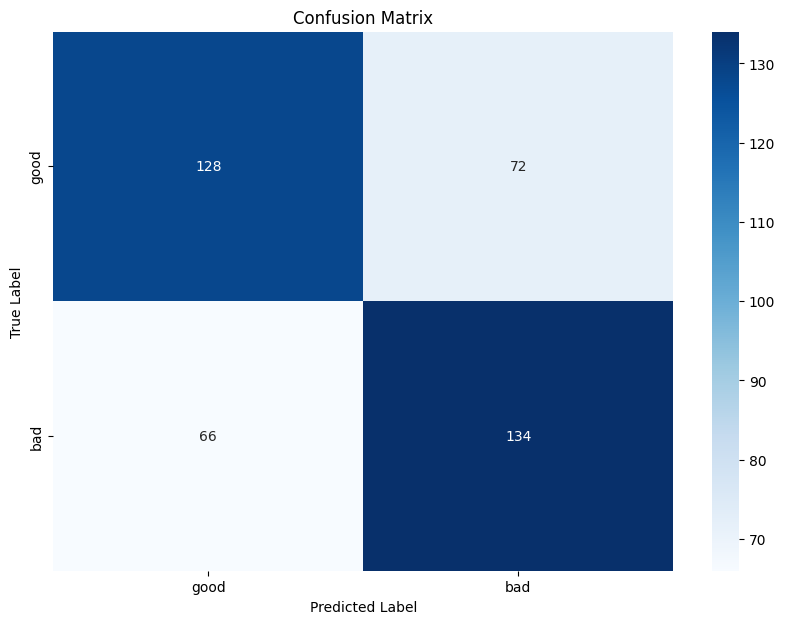

current accuracy on test tensor(65.5000, device='cuda:0')
current AUC on test 73.22500000000001
Epoch: 8 Iteration: 0 0.5730648636817932 tensor(14., device='cuda:0')
accuracy on trian tensor(0.8675, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 73.36it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 74.79it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 74.76it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 72.64it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


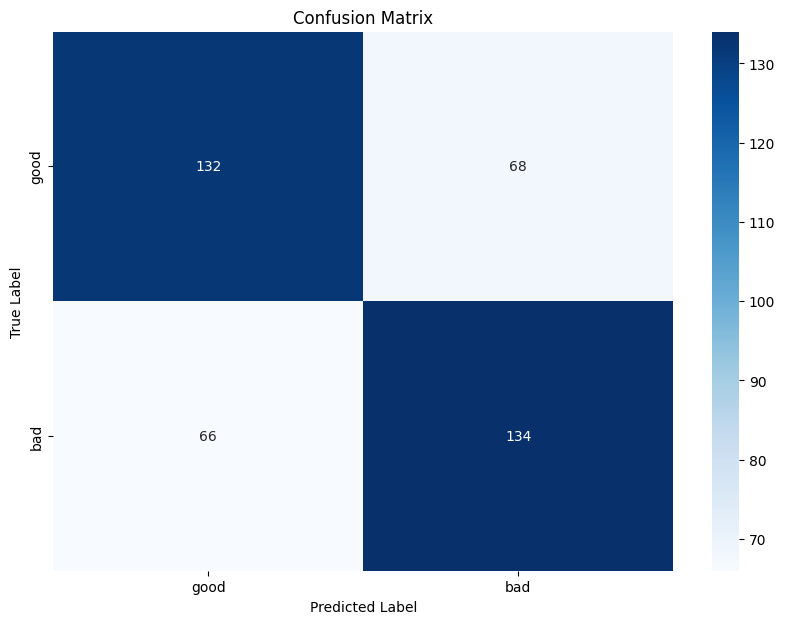

current accuracy on test tensor(66.5000, device='cuda:0')
current AUC on test 72.9775
Epoch: 9 Iteration: 0 0.7806879878044128 tensor(13., device='cuda:0')
accuracy on trian tensor(0.8800, device='cuda:0')
Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 76.45it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 0


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 73.48it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 1


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 65.86it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 2


Adding exntity information? False
Adding demographic information? False
Using target information? False
Mapping for label 0, word good, index 205
Mapping for label 1, word bad, index 1099
Template: *<s>**sent_0*.*_It_was*label_**</s>*
Template list: ['', '<s>', '', 'sent_0', '.', '_It_was', 'label_', '', '</s>', '']
Length of supporting example: 400


100%|██████████| 1/1 [00:00<00:00, 74.47it/s]

The length of the dataset for: test is: 400
Length of test set: 400 Query: 3


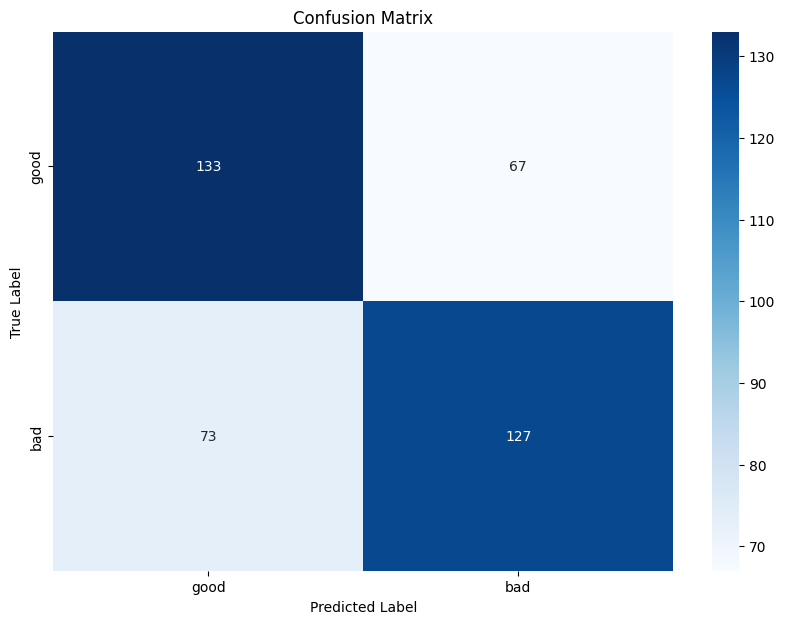

current accuracy on test tensor(65., device='cuda:0')
current AUC on test 72.0125


In [63]:
import torch
import numpy as np
import random

# import config
import os
# from train import train_for_epoch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer
from transformers import DistilBertTokenizer


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


    
# Example of creating an instance
# change the epochs here and run the model again 
config = ModelConfig(
    DATASET="harm", FEW_SHOT=False, FINE_GRIND=False, NUM_SHOTS=16, MODEL="pbm", UNIMODAL=False,
    DATA="/kaggle/input", CAPTION_PATH="/kaggle/input", RESULT="/kaggle/working", FEAT_DIM=2048, CLIP_DIM=512,
    BERT_DIM=768, ROBERTA_DIM=1024, NUM_FOLD=5, EMB_DIM=300, NUM_LABELS=2, POS_WORD="good",
    NEG_WORD="bad", DEM_SAMP=False, SIM_RATE=0.5, IMG_RATE=0.5, TEXT_RATE=0.5, CLIP_CLEAN=False,
    MULTI_QUERY=True, NUM_QUERIES=4, EMB_DROPOUT=0.0, FC_DROPOUT=0.4, WEIGHT_DECAY=0.01, LR_RATE=1.3e-5,
    EPS=1e-8, BATCH_SIZE=16, FIX_LAYERS=2, MID_DIM=512, NUM_HIDDEN=512, LENGTH=64, TOTAL_LENGTH=256,
    PREFIX_LENGTH=10, NUM_SAMPLE=1, NUM_LAYER=8, MODEL_NAME="roberta-large", PRETRAIN_DATA="conceptual",
    IMG_VERSION="clean", MAPPING_TYPE="transformer", ADD_ENT=True, ADD_DEM=True, DEBUG=False, SAVE=False,
    SAVE_NUM=100, EPOCHS=10, SEED=1111, CUDA_DEVICE=15, WARM_UP=2000, TRANS_LAYER=1, NUM_HEAD=8,IMAGE_FOLDER='/content/drive/MyDrive/meme/data',BASE_MODEL='roberta-base'
)
if __name__=='__main__':
    opt=config
    # torch.cuda.set_device(opt.CUDA_DEVICE)
    set_seed(opt.SEED)


    # Create tokenizer
    tokenizer = RobertaTokenizer.from_pretrained(opt.BASE_MODEL)
#     tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    constructor='build_baseline'
    if opt.MODEL=='pbm':
        # from dataset import Multimodal_Data
        # import baseline
        train_set=Multimodal_Data(opt,tokenizer,opt.DATASET,'train',opt.SEED-1111)
        test_set=Multimodal_Data(opt,tokenizer,opt.DATASET,'test')
        label_list=[train_set.label_mapping_id[i] for i in train_set.label_mapping_word.keys()]
        model = build_baseline(opt, label_list).cuda()
    else:
        # from roberta_dataset import Roberta_Data
        # import roberta_baseline
        # train_set=Roberta_Data(opt,tokenizer,opt.DATASET,'train',opt.SEED-1111)
        # test_set=Roberta_Data(opt,tokenizer,opt.DATASET,'test')
        # model=getattr(roberta_baseline,constructor)(opt).cuda()
        pass

    train_loader=DataLoader(train_set,
                            opt.BATCH_SIZE,
                            shuffle=True,
                            num_workers=1)
    test_loader=DataLoader(test_set,
                           opt.BATCH_SIZE,
                           shuffle=False,
                           num_workers=1)
    train_for_epoch(opt,model,train_loader,test_loader)

#     exit(0)


In [64]:
    # Save the model
    model_save_path = os.path.join(opt.RESULT, 'model-low_resource_400_gpt_10_harm_without_ent_without_dem.pth')
    torch.save(model.state_dict(), model_save_path) 
    print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/model-low_resource_400_gpt_10_harm_without_ent_without_dem.pth


## Only run this code if you run changing epochs


In [65]:
# opt = ModelConfig(
#     DATASET="harm", FEW_SHOT=False, FINE_GRIND=False, NUM_SHOTS=16, MODEL="pbm", UNIMODAL=False,
#     DATA="/kaggle/input", CAPTION_PATH="/kaggle/input", RESULT="/kaggle/working", FEAT_DIM=2048, CLIP_DIM=512,
#     BERT_DIM=768, ROBERTA_DIM=1024, NUM_FOLD=5, EMB_DIM=300, NUM_LABELS=2, POS_WORD="not hateful",
#     NEG_WORD="hateful", DEM_SAMP=False, SIM_RATE=0.5, IMG_RATE=0.5, TEXT_RATE=0.5, CLIP_CLEAN=False,
#     MULTI_QUERY=True, NUM_QUERIES=4, EMB_DROPOUT=0.0, FC_DROPOUT=0.4, WEIGHT_DECAY=0.01, LR_RATE=1.3e-5,
#     EPS=1e-8, BATCH_SIZE=16, FIX_LAYERS=2, MID_DIM=512, NUM_HIDDEN=512, LENGTH=64, TOTAL_LENGTH=256,
#     PREFIX_LENGTH=10, NUM_SAMPLE=1, NUM_LAYER=8, MODEL_NAME="roberta-large", PRETRAIN_DATA="conceptual",
#     IMG_VERSION="clean", MAPPING_TYPE="transformer", ADD_ENT=True, ADD_DEM=True, DEBUG=False, SAVE=False,
#     SAVE_NUM=100, EPOCHS=1, SEED=1111, CUDA_DEVICE=15, WARM_UP=2000, TRANS_LAYER=1, NUM_HEAD=8,IMAGE_FOLDER='/content/drive/MyDrive/meme/data',
#     BASE_MODEL='roberta-base'
# )

In [66]:
# # Example label list (replace this with your actual label list)
# tokenizer = RobertaTokenizer.from_pretrained(opt.BASE_MODEL)
# train_set=Multimodal_Data(opt,tokenizer,opt.DATASET,'train',opt.SEED-1111)
# label_list = [train_set.label_mapping_id[i] for i in train_set.label_mapping_word.keys()]

# # Build the model
# model = build_baseline(opt, label_list)
# compile
# # Load the state dictionary
# model_path = '/kaggle/working/model-gpt_Desc-3.pth'
# state_dict = torch.load(model_path)

# # Load the state dictionary into the model
# model.load_state_dict(state_dict)

# # Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [67]:
# Assuming `opt` is already defined and `eval_multi_model` is your evaluation function
# print(eval_multi_model(opt, model, tokenizer))

In [68]:
torch.cuda.empty_cache()